In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Aug 13 17:35:31 2023
Updated on Sun Feb 02 08:00:31 2025 (wow, 1.5 years passed...)

@author: joao
"""

FTB_RATIO = 1.0  # floor size to building ratio constant (matches blender)

In [12]:
" Run Blender "
import subprocess

command = ["/home/joao/blender-3.6.0-linux-x64/blender",
           "--background",
           "--python",
           "/mnt/c/Users/jmora/Documents/GitHub/AutoRayTracing/scene_creation.py"
          ]
#try:
#    result = subprocess.run(command, check=True, text=True, capture_output=True)
#    print("Output:", result.stdout)
#except subprocess.CalledProcessError as e:
#    print("Error:", e.stderr)

In [2]:
import os
import sys
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sionna
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, DirectivePattern
from sionna.channel import ApplyTimeChannel, cir_to_ofdm_channel

from tqdm import tqdm
import mitsuba as mi
import drjit as dr
import time
from scipy.io import loadmat, savemat
import pandas as pd

with open('scenes_folder.txt', 'r') as fp:
    root_folder = fp.read()[:-1] # no newline

print(root_folder) ######## SHOULD HAVE WRITTEN THE PATH OBTAINED FROM BLENDER -> WE SHOULD HAVE BLENDER 3.6 INSTALLED IN WSL too

/mnt/c/Users/jmora/Documents/GitHub/AutoRayTracing/all_runs/run_02-02-2025_15H45M26S/


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# Classes
class Shape:
    
    # bbox Mitsuba API: https://mitsuba.readthedocs.io/en/stable/src/api_reference.html#mitsuba.ScalarBoundingBox3f
    def __init__(self, shape):
        self.id = shape.id()
        self.shape = shape
        params = mi.traverse(shape)
        self.faces = dr.unravel(mi.Point3f, params['faces']).numpy()
        self.vertices = dr.unravel(mi.Point3f, params['vertex_positions']).numpy()
        self.bbox = shape.bbox()
        
    def get_vertices(self):
        return self.vertices
    
    def get_faces(self):
        return self.faces

    def contains(self, pos):
        return self.bbox.contains(pos)

    def get_size(self):
        return self.bbox.extents()

    def get_3d_area(self):
        return self.bbox.surface_area()

    def get_volume(self):
        return self.bbox.volume()

    def get_bbox_corners(self):
        return self.bbox.min, self.bbox.max

    def get_height(self):
        return self.bbox.max[2] - self.bbox.min[2]
        
    def get_center(self):
        return self.bbox.center

    def get_distance(self, target):
        return self.bbox.distance(target)

    def get_bbox(self):
        return self.bbox

    def get_bbox_bottom_vertices(self):
        return [self.bbox.corner(i) for i in range(4)]
    
    def get_bbox_top_vertices(self):
        return [self.bbox.corner(4+i) for i in range(4)]

    def get_bbox_vertices(self):
        return [self.bbox.corner(i) for i in range(8)]
    

# Functions
def print_all_shapes_in_scene(scene):
    for shape in scene.mi_scene.shapes():
        print(shape.id())

def get_floor_from_scene(scene):
    floor_shape = None
    for shape in scene.mi_scene.shapes():
        if shape.id() == 'mesh-floor':
            floor_shape = shape
            break

    return shape

def get_buildings_from_scene(scene):
    buildings = []
    for shape in scene.mi_scene.shapes():
        if shape.id() != 'mesh-floor':
            buildings.append(shape)

    return buildings

def compute_array_combinations(arrays):
    return np.stack(np.meshgrid(*arrays), -1).reshape(-1, len(arrays))

def gen_user_grid(box_corners, steps, no_zones=None, box_offsets=None):
    """
    box_corners is = [bbox_min_corner, bbox_max_corner]
    steps = [x_step, y_step, z_step]
    no_zones = [list of Shapes with a contains() method]
    """

    # Sample the ranges of coordinates
    ndim = len(box_corners[0])
    dim_ranges = []
    for dim in range(ndim):
        if steps[dim]:
            dim_range = np.arange(box_corners[0][dim], box_corners[1][dim], steps[dim])
        else:
            dim_range = np.array([box_corners[0][dim]]) # select just the first limit
        
        dim_ranges.append(dim_range + box_offsets[dim] if box_offsets else 0)
    
    dims = [len(r) if len(r) else 1 for r in dim_ranges]
    print(f'Grid dimensions: {dims}')
    
    n_total = np.prod(dims)
    print(f'Total positions covering the ground plane: {n_total}')
    
    # Compute combination of sampled ranges
    positions = compute_array_combinations(dim_ranges)
    
    # Determine which positions are inside no_zones
    idxs_in_nozone = np.zeros(positions.shape[0], dtype=bool)
    for pos_idx in tqdm(range(n_total), desc='Intersecting positions with no-zones (e.g. buildings)'):
        for no_zone in no_zones:
            if no_zone.contains(positions[pos_idx]):
                idxs_in_nozone[pos_idx] = True
                break
    
    # Include only the positions that are outside no zones
    idxs_to_include = np.invert(idxs_in_nozone)
    
    n_total_after_filtering = sum(idxs_to_include)
    print(f'Total positions outside of buildings: {n_total_after_filtering}')
    
    return positions[idxs_to_include]

def is_notebook() -> bool:
    is_notebook = False
    try:
        shell = get_ipython().__class__.__name__
        module = get_ipython().__class__.__module__
    except NameError:
        return False # Probably standard Python interpreter
        
    if shell == 'ZMQInteractiveShell':
        is_notebook = True   # Jupyter notebook or qtconsole
    elif module == 'google.colab._shell':
        is_notebook = True   # Colab notebook
    elif shell == 'TerminalInteractiveShell':
        is_notebook = False  # Terminal running IPython
    else:
        is_notebook = False  # Other type (?)

    return is_notebook

def create_base_scene(scene_path, center_frequency):
    scene = load_scene(scene_path)
    scene.frequency = center_frequency
    scene.tx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    scene.rx_array = scene.tx_array
    scene.synthetic_array = True
    
    return scene

In [5]:
# Read parameters from CSV
df = pd.read_csv('params.csv')

# Compute simulations for each row
n_rows = df.index.stop

for row_idx in range(n_rows):
    carrier_freq = df['freq (ghz)'][row_idx] * 1e9
    n_reflections = 3#df['n_reflections'][row_idx]
    
    if not np.isnan(df['bs_lat'][row_idx]):
        tx_pos = [df['bs_lat'][row_idx], df['bs_lon'][row_idx], df['bs_alt'][row_idx]]
    else:
        tx_pos = None # placed automatically on building closest to the center
    
    # tx_pos = [-33, 11, 32.03]
    
    scattering = bool(df['scattering'][row_idx])
    diffraction = bool(df['diffraction'][row_idx])
    
    x_step = 2#df['x_step'][row_idx]
    y_step = 2#df['y_step'][row_idx]
    z_step = df['z_step'][row_idx]

    print(f'Running RT simulation for row {row_idx+1} (starts at 1):\n'
          f'n_reflections = {n_reflections}\n'
          f'tx_pos = {tx_pos}\n'
          f'scattering = {scattering}\n'
          f'diffraction = {diffraction}\n'
          f'[x_step, y_step, z_step] = [{x_step}, {y_step}, {z_step}]\n')

    # 0- Create/Fetch scene and get buldings in the scene
    #scene_name = sionna.rt.scene.simple_street_canyon
    scene_folder = root_folder + f'scen_{row_idx}/'
    scene_name = scene_folder + 'scene.xml'
    scene = create_base_scene(scene_name, center_frequency=carrier_freq)
    # scene = create_base_scene(sionna.rt.scene.simple_street_canyon, center_frequency=carrier_freq)
    buildings = [Shape(building) for building in get_buildings_from_scene(scene)][:-1] 
    # (unkown last building in bottom left corner...)

    # 1- Compute TX position
    print('Computing BS position')

    if not tx_pos:
        # 1.1- Find the building closest to the center of the scene ([0,0,0])
        distances = [building.get_distance([0,0,0]) for building in buildings]
        heights = [building.get_height() for building in buildings]
        building_score = [
            heights[b]**2 / distances[b] if distances[b] > 0 else float('-inf') # ignore terrain
            for b in range(len(buildings))
        ]
        best_building_idx = np.argmax(building_score)
        closest_building = buildings[best_building_idx]
    
        # 1.2- Find closest vertice to the origin (at height)
        best_building_vertices = closest_building.get_vertices()
        # use a high point at the origin to force the selection of a roof vertice
        vertice_distances = [np.linalg.norm(vert - [0,0,1e5]) for vert in best_building_vertices]
        closest_vertice_idx = np.argmin(vertice_distances)
        closest_vertice = best_building_vertices[closest_vertice_idx]
        
        # 1.3- Put transmitter 2 metters above that vertice
        tx_pos = closest_vertice + [0,0,2]

    # 1.4- Add transmitter to the scene
    scene.add(Transmitter(name="tx",
                          position=tx_pos,
                          orientation=[0,0,0]))

    # 2- Compute RXs positions
    print('Computing UEs positions')
    
    # 2.1- Get limits of the floor
    floor_shape = Shape(get_floor_from_scene(scene))
    min_corner, max_corner = floor_shape.get_bbox_corners()

    # 2.2- Distribute users uniformely 1.5m above the floor
    rxs = gen_user_grid(box_corners=[min_corner / FTB_RATIO, max_corner / FTB_RATIO],
                        steps=[x_step, y_step, z_step],
                        no_zones=buildings,
                        box_offsets=[0, 0, 1.5])

    # 2.3- Add the first batch of receivers to the scene
    n_rx = len(rxs)
    n_rx_in_scene = 20 if not scattering else 7
    print(f'Adding users to the scene ({n_rx_in_scene} at a time)')
    for rx_idx in range(n_rx_in_scene):
        scene.add(Receiver(name=f"rx_{rx_idx}",
                           position=rxs[rx_idx],
                           orientation=[0,0,0]))

    # 3- Compute paths
    # 3.1- Enable scattering in the radio materials
    if scattering:
        for rm in scene.radio_materials.values():
            rm.scattering_coefficient = 1/np.sqrt(3) # [0,1]
            rm.scattering_pattern = DirectivePattern(alpha_r=10)
            

    # 3.2- Compute the paths for each set of receiver positions
    path_list = []
    n_rx_remaining = n_rx
    for x in tqdm(range(int(n_rx / n_rx_in_scene)+1), desc='Path computation'):
        if n_rx_remaining > 0:
            n_rx_remaining -= n_rx_in_scene
        else:
            break
        if x != 0:
            # modify current RXs in scene
            for rx_idx in range(n_rx_in_scene):
                if rx_idx + n_rx_in_scene*x < n_rx:
                    scene.receivers[f'rx_{rx_idx}'].position = rxs[rx_idx + n_rx_in_scene*x]
                else:
                    # remove the last receivers in the scene
                    scene.remove(f'rx_{rx_idx}')
        
        # Save dict with compute path params to export later
        my_compute_path_params = dict(
            max_depth=n_reflections,
            num_samples=1e6,
            scattering=scattering,
            diffraction=diffraction
        )
        
        paths = scene.compute_paths(**my_compute_path_params)
        
        paths.normalize_delays = False  # sum min_tau to tau, or else the first path tau is always = 0
        
        path_list.append(paths)

Running RT simulation for row 1 (starts at 1):
n_reflections = 3
tx_pos = None
scattering = False
diffraction = True
[x_step, y_step, z_step] = [2, 2, 0]

Computing BS position
Computing UEs positions
Grid dimensions: [44, 33, 1]
Total positions covering the ground plane: 1452


Intersecting positions with no-zones (e.g. buildings): 100%|███████████████| 1452/1452 [00:05<00:00, 284.06it/s]


Total positions outside of buildings: 1452
Adding users to the scene (20 at a time)


Path computation: 100%|█████████████████████████████████████████████████████████| 73/73 [02:33<00:00,  2.10s/it]


In [6]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

# Sionna Exporter
Takes the scene and a List[Paths] (or just one Paths object) and exports them to a format compatible with DeepMIMO.
Note, this "exporter" is necessary because most of Sionna objects have no export/save functionality.

In [7]:
from typing import Tuple, List, Dict, Any
import pickle

Paths = sionna.rt.Paths  # shorter type for Paths
Scene = sionna.rt.Scene  # shorter type for Scene

def save_to_pickle(obj, filename):
    """Saves an object to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

def load_from_pickle(filename):
    """Loads an object from a pickle file."""
    with open(filename, 'rb') as file:
        return pickle.load(file)

def export_paths(path_list: List[Paths] | Paths) -> List[dict]:
    """Exports paths to a filtered dictionary with only selected keys """
    relevant_keys = ['sources', 'targets', 'a', 'tau', 'phi_r', 'phi_t', 
                     'theta_r', 'theta_t', 'types', 'vertices']
    
    path_list = [path_list] if type(path_list) != list else path_list
    
    paths_dict_list = []
    for obj_idx, path_obj in enumerate(path_list):
        path_dict = path_obj.to_dict()
        
        # filter unnecessary keys
        dict_filtered = {key: path_dict[key].numpy() for key in relevant_keys}
        
        # add dict to final list
        paths_dict_list += [dict_filtered]
    return paths_dict_list

def scene_to_dict(scene: Scene) -> Dict[str, Any]: 
    """ Export a Sionna Scene to a dictionary, like to Paths.to_dict() """
    members_names = dir(scene)
    members_objects = [getattr(scene, attr) for attr in members_names]
    data = {attr_name[1:] : attr_obj for (attr_obj, attr_name)
            in zip(members_objects, members_names)
            if not callable(attr_obj) and
               not isinstance(attr_obj, sionna.rt.Scene) and
               not attr_name.startswith("__") and
               attr_name.startswith("_")}
    return data

def export_scene_materials(scene: Scene) -> Tuple[List[Dict[str, Any]], List[int]]:
    
    scene_dict = scene_to_dict(scene)
    materials_predefined = scene_dict['radio_materials']
    
    obj_materials = []
    for obj_name, obj in scene._scene_objects.items():
        #print(f'obj_name = {obj_name}')
        #print(f'obj_mat = {obj.radio_material}')
        obj_materials += [obj.radio_material]
    
    unique_materials = set(obj_materials)
    unique_mat_names = [mat.name for mat in unique_materials]
    
    n_objs = len(scene._scene_objects)
    obj_mat_indices = np.zeros(n_objs, dtype=int)
    for obj_idx, obj_mat in enumerate(obj_materials):
        obj_mat_indices[obj_idx] = unique_mat_names.index(obj_mat.name)
    
    # Do some light processing to add dictionaries to a list in a pickable format
    materials_dict_list = []
    for material in unique_materials:
        materials_dict = {
            'name': material.name,
            'conductivity': material.conductivity.numpy(),
            'relative_permeability': material.relative_permeability.numpy(),
            'relative_permittivity': material.relative_permittivity.numpy(),
            'scattering_coefficient': material.scattering_coefficient.numpy(),
            'scattering_pattern': type(material.scattering_pattern).__name__,
            'alpha_r': material.scattering_pattern.alpha_r,
            'alpha_i': material.scattering_pattern.alpha_i,
            'lambda_': material.scattering_pattern.lambda_.numpy(),
            'xpd_coefficient': material.xpd_coefficient.numpy(),   
        }
        materials_dict_list += [materials_dict]

    return materials_dict_list, obj_mat_indices

def export_scene_rt_params(scene: Scene, **compute_paths_kwargs) -> Dict[str, Any]:
    """ Extract parameters from Scene (and from compute_paths arguments)"""
    
    scene_dict = scene_to_dict(scene)
    rt_params_dict = dict(
        bandwidth=scene_dict['bandwidth'].numpy(),
        frequency=scene_dict['frequency'].numpy(),
        
        rx_array_size=scene_dict['rx_array'].array_size,  # dual-pol if diff than num_ant
        rx_array_num_ant=scene_dict['rx_array'].num_ant,
        rx_array_ant_pos=scene_dict['rx_array'].positions.numpy(),  # relative to ref.
        
        tx_array_size=scene_dict['tx_array'].array_size, 
        tx_array_num_ant=scene_dict['tx_array'].num_ant,
        tx_array_ant_pos=scene_dict['tx_array'].positions.numpy(),
    
        synthetic_array=scene_dict['synthetic_array'],
    
        # custom
        raytracer_version=sionna.__version__,
        doppler_available=0,
    )

    default_compute_paths_params = dict( # with Sionna default values
        max_depth=3, 
        method='fibonacci',
        num_samples=1000000,
        los=True,
        reflection=True,
        diffraction=False,
        scattering=False,
        scat_keep_prob=0.001,
        edge_diffraction=False,
        scat_random_phases=True
    )
    
    # Note 1: Sionna considers only last-bounce diffusion (except in compute_coverage(.), 
    #         but that one doesn't return paths)
    # Note 2: Sionna considers only one diffraction (first-order diffraction), 
    #         though it may occur anywhere in the path
    # Note 3: Sionna does not save compute_path(.) argument values. 
    #         Many of them cannot be derived from the paths and scenes.
    #         For this reason, we ask the user to define a dictionary with the 
    #         parameters we care about and raytrace using that dict.
    #         Alternatively, the user may fill the dictionary after ray tracing with 
    #         the parameters that changed from their default values in Sionna.

    # Update default parameters of compute_path(.) with parameters that changed (in kwargs)
    default_compute_paths_params.update(compute_paths_kwargs)

    return {**rt_params_dict, **default_compute_paths_params}

def export_scene_buildings(scene: Scene) -> Tuple[np.ndarray, Dict]:
    """ Export the vertices and faces of buildings in a Sionna Scene.
    Output:
        vertice_matrix: n_vertices_in_scene x 3 (xyz coordinates)
        obj_index_map: Dict with object name as key and (start_idx, end_idx) as value
    """
    all_vertices = []
    obj_index_map = {}  # Stores the name and starting index of each object
    
    vertex_offset = 0
    
    for obj_name, obj in scene._scene_objects.items():
    
        # Get vertices
        n_v = obj._mi_shape.vertex_count()
        obj_vertices = np.array(obj._mi_shape.vertex_position(np.arange(n_v)))
        
        # Append vertices to global list
        all_vertices.append(obj_vertices)
    
        # Store object index range
        obj_index_map[obj_name] = (vertex_offset, vertex_offset + n_v)
        
        # Update vertex offset
        vertex_offset += n_v
    
    # Convert lists to numpy arrays
    all_vertices = np.vstack(all_vertices)

    return all_vertices, obj_index_map


def export_sionna_to_deepmimo(scene: Scene, path_list: List[Paths] | Paths, 
                              my_compute_path_params: Dict, save_folder: str):
    """ Export a complete Sionna simulation to a format that can be converted by DeepMIMO """
    
    paths_dict_list = export_paths(path_list)
    materials_dict_list, material_indices = export_scene_materials(scene)
    rt_params = export_scene_rt_params(scene, **my_compute_path_params)
    vertice_matrix, objects_dict = export_scene_buildings(scene)
    
    os.makedirs(save_folder, exist_ok=True)
    
    save_vars_dict = {
        # filename: variable_to_save
        'sionna_paths.pkl': paths_dict_list,
        'sionna_materials.pkl': materials_dict_list,
        'sionna_material_indices.pkl': material_indices,
        'sionna_rt_params.pkl': rt_params,
        'sionna_vertices.pkl': vertice_matrix,
        'sionna_objects.pkl': objects_dict,
    }
    
    for filename, variable in save_vars_dict.items():
        save_to_pickle(variable, save_folder + filename)

    return

In [8]:
# Define save folder and save all objects
save_folder = scene_folder + 'sionna_export_test/'
export_sionna_to_deepmimo(scene, path_list, my_compute_path_params, save_folder)

In [10]:
# For testing without installing the pack, add the sys path to deepmimo so the import works
# import sys
# isys.path..
from deepmimo.converter.sionna_rt import sionna_exporter
sionna_exporter.export_sionna_to_deepmimo(scene, path_list, my_compute_path_params, scene_folder + 'sionna_export_test2/')

In [11]:
# Test loading
from pprint import pprint
def import_sionna_for_deepmimo(save_folder: str):
    
    saved_vars_names = [
        'sionna_paths.pkl',
        'sionna_materials.pkl',
        'sionna_material_indices.pkl',
        'sionna_rt_params.pkl',
        'sionna_vertices.pkl',
        'sionna_faces.pkl',
        'sionna_objects.pkl',
    ]
    
    for filename in saved_vars_names:
        variable = load_from_pickle(save_folder + filename)
        
    return

scene_folder = root_folder + f'scen_0/'
save_folder = scene_folder + 'sionna_test/'
p = load_from_pickle(save_folder + 'sionna_paths.pkl')
v = load_from_pickle(save_folder + 'sionna_vertices.pkl')
o = load_from_pickle(save_folder + 'sionna_objects.pkl')


Processing: building_1
  Vertices count: 14
  Faces count: 12
  Adjusted face indices (absolute):
[[0 1 2]
 [0 2 3]
 [3 2 4]
 [3 4 5]
 [5 4 6]]
  Sample vertices (after offset correction):
[[-6.2107651e+01 -8.6133347e+00 -3.0794144e-02]
 [-6.2107651e+01 -8.6133347e+00  2.1815460e+01]
 [-6.2107651e+01 -3.6499641e+01  2.1815460e+01]]
  Sample face indices:
[[0, 1, 2], [0, 2, 3], [3, 2, 4]] (relative)
  Sample face indices:
[[0, 1, 2], [0, 2, 3], [3, 2, 4]] (absolute)

Processing: building_6
  Vertices count: 14
  Faces count: 12
  Adjusted face indices (absolute):
[[14 15 16]
 [14 16 17]
 [17 16 18]
 [17 18 19]
 [19 18 20]]
  Sample vertices (after offset correction):
[[-1.5119010e+01 -8.6133347e+00 -3.0794144e-02]
 [-1.5119010e+01 -8.6133347e+00  5.0943810e+01]
 [-1.5119010e+01 -3.6499641e+01  5.0943810e+01]]
  Sample face indices:
[[0, 1, 2], [0, 2, 3], [3, 2, 4]] (relative)
  Sample face indices:
[[14, 15, 16], [14, 16, 17], [17, 16, 18]] (absolute)

Processing: building_5
  Vertices

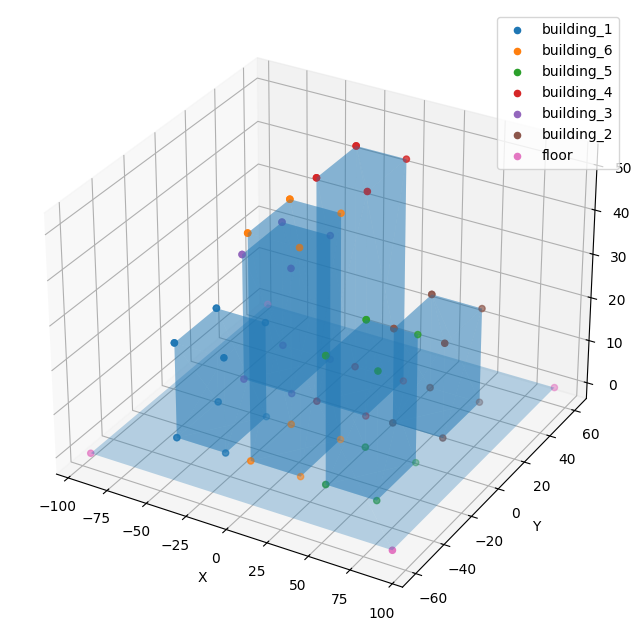


Final Object Index Map: {'building_1': (0, 14), 'building_6': (14, 28), 'building_5': (28, 42), 'building_4': (42, 56), 'building_3': (56, 70), 'building_2': (70, 84), 'floor': (84, 88)}


In [166]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

all_vertices = []
all_faces = []
obj_index_map = {}  # Stores the name and starting index of each object

vertex_offset = 0

# Dictionary to store per-object data for debugging
object_data = {}

for obj_name, obj in scene._scene_objects.items():
    print(f"\nProcessing: {obj_name}")

    # Get vertices
    n_v = obj._mi_shape.vertex_count()
    obj_vertices = np.array(obj._mi_shape.vertex_position(np.arange(n_v)))  # Ensure NumPy conversion
    print(f"  Vertices count: {n_v}")

    # Apply position offset correction
    if False:
        obj_pos_2d = obj.position.numpy().copy()  # Get position
        obj_pos_2d[2] = 0  # Set Z to zero to avoid shifting up
        obj_vert_offset = obj_vertices + obj_pos_2d  # Apply only X, Y offset
    else:
        obj_vert_offset = obj_vertices

    # Append vertices to global list
    all_vertices.append(obj_vert_offset)

    # Store object index range
    obj_index_map[obj_name] = (vertex_offset, vertex_offset + n_v)
    
    # Get faces with corrected indices
    n_f = obj._mi_shape.face_count()
    obj_faces = np.array(obj._mi_shape.face_indices(np.arange(n_f)))  # Ensure NumPy conversion
    print(f"  Faces count: {n_f}")

    # Adjust face indices to be absolute
    obj_faces_absolute = obj_faces + vertex_offset  
    
    # Print debug information AFTER correction
    print(f"  Adjusted face indices (absolute):\n{obj_faces_absolute[:5]}")
    
    # Check max index after correction
    max_index_after = obj_faces_absolute.max()
    if max_index_after >= vertex_offset + n_v:
        print(f"⚠️ ERROR: Face index {max_index_after} is out of bounds after correction!")
        print(f"  Expected max index: {vertex_offset + n_v - 1}")
        print(f"  Face indices (absolute):\n{obj_faces_absolute[:5]}")
        print(f"  Vertex Offset: {vertex_offset}")
        print(f"  Num Vertices in Object: {n_v}")
        raise IndexError(f"Face index out of range after correction in {obj_name}.")

    # **Debugging: Check if faces reference out-of-bounds indices**
    max_face_index = obj_faces_absolute.max()
    if max_face_index >= vertex_offset + n_v:
        print(f"⚠️ ERROR in {obj_name}: Face index {max_face_index} is out of bounds!")
        print(f"  Expected max index: {vertex_offset + n_v - 1}")
        print(f"  Face indices (absolute):\n{obj_faces_absolute[:5]}")
        print(f"  Vertex Offset: {vertex_offset}")
        print(f"  Num Vertices in Object: {n_v}")
        raise IndexError(f"Face index {max_face_index} exceeds available vertices.")

    # Append faces to global list
    all_faces.append(obj_faces_absolute)

    # Store debug data
    object_data[obj_name] = {
        "vertices": obj_vert_offset,
        "faces": obj_faces_absolute,
    }

    # Print some vertex values for debugging
    print(f"  Sample vertices (after offset correction):\n{obj_vert_offset[:3]}")
    print(f"  Sample face indices:\n{obj_faces[:3].tolist()} (relative)")
    print(f"  Sample face indices:\n{obj_faces_absolute[:3].tolist()} (absolute)")

    # Update vertex offset
    vertex_offset += n_v

# Convert lists to numpy arrays
all_vertices = np.vstack(all_vertices)
all_faces = np.vstack(all_faces)

# Debug: Unique vertices check
unique_vertices = np.unique(all_vertices, axis=0)
print(f"\nTotal vertices: {all_vertices.shape[0]}")
print(f"Unique vertices: {unique_vertices.shape[0]}")

# Debug: Check if buildings share vertices
for (name1, (start1, end1)), (name2, (start2, end2)) in zip(obj_index_map.items(), list(obj_index_map.items())[1:]):
    shared = set(range(start1, end1)).intersection(set(range(start2, end2)))
    if shared:
        print(f"WARNING: {name1} and {name2} share vertices: {shared}")

# Plot scene for visualization
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for obj_name, data in object_data.items():
    vertices = data["vertices"]  # Local object vertices
    faces = data["faces"]  # Absolute global face indices

    # Plot vertices
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], label=obj_name)

    # Fix: Use the global vertex array for face plotting
    for face in faces:
        try:
            poly = [all_vertices[i] for i in face]  # Use global vertex array
            ax.add_collection3d(Poly3DCollection([poly], alpha=0.3))
        except IndexError as e:
            print(f"\n🚨 Face Index Error in {obj_name}: {e}")
            print(f"  Face: {face}")
            print(f"  Max allowed index: {len(all_vertices)-1}")
            raise  # Stop execution if an invalid face index is detected.

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()


print("\nFinal Object Index Map:", obj_index_map)
